<font size="6">**Seasonality**</font>

In [1]:

import numpy as np
import seaborn as sns

from sklearn.model_selection import (TimeSeriesSplit, cross_validate)
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run ../nb_config.py

running notebook configuration


In [4]:
from src.load_data import market_data
from src.mle import time_series as mle_ts
from src import utils

# Parameters

In [5]:
KFOLDS = 3

In [6]:
def wrap_cv_res(cv_res, label, score, factor=-1):
    cv_res_df = pd.DataFrame(cv_res).rename(columns={'test_score': f'cv_test_{score}'})
    cv_res_df.index.name = "kfold"
    cv_res_df['model'] = label
    cv_res_df.set_index('model',append=True, inplace=True)
    cv_res_df[ f'cv_test_{score}'] *= factor

    return cv_res_df

In [7]:
def get_preds(X: pd.DataFrame, model, name='preds'):
    return pd.Series(index=X.index, data=model.predict(X), name=name)
    

# Load Data

In [8]:
cnmc_df = market_data.read_cnmc_data()[['cons_GOA']] * 1e-6

In [9]:
cnmc_df['month'] = cnmc_df.index.month
cnmc_df['qtr'] = cnmc_df.index.quarter

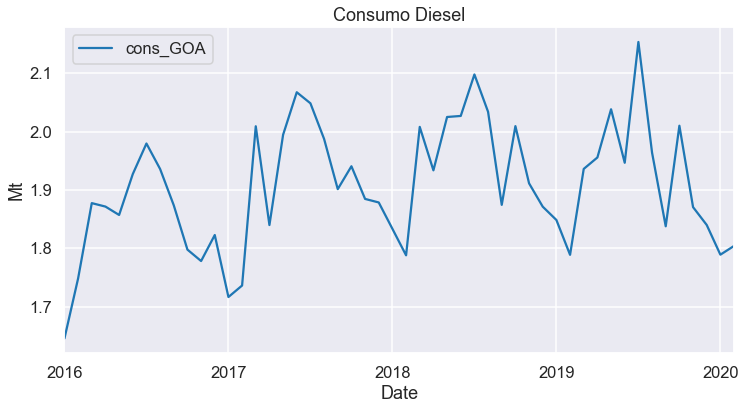

In [10]:
cnmc_df.plot(y='cons_GOA', title='Consumo Diesel')
plt.ylabel("Mt")
plt.show()

# Cross Validation

## Time Series Split

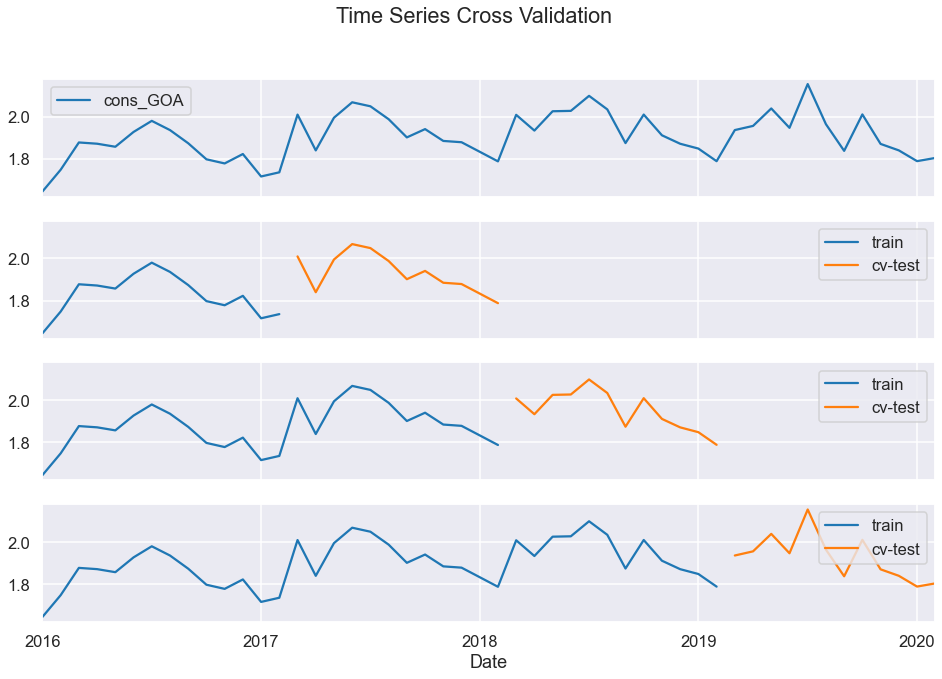

In [11]:
tscv = TimeSeriesSplit(n_splits=KFOLDS)
sp_tscv  = tscv.split(cnmc_df['cons_GOA'])

fig, axs = plt.subplots(KFOLDS+1, 1, sharex=True, sharey=True, figsize=(16,10))

ax = axs[0]
cnmc_df.plot(y='cons_GOA', ax=ax)

for idx_row, (train_index, test_index) in enumerate(sp_tscv):
    ax = axs[idx_row+1]
    cnmc_df.iloc[train_index].plot(y='cons_GOA', label='train', ax=ax)
    cnmc_df.iloc[test_index].plot(y='cons_GOA', label='cv-test' , ax=ax)

plt.suptitle('Time Series Cross Validation')
plt.show()

In [12]:
seas_ohe_model = LinearRegression(fit_intercept=True)
tscv = TimeSeriesSplit(n_splits=KFOLDS)

seas_ohe_qtr_cv = cross_validate(
    seas_ohe_model,
    X=pd.get_dummies(cnmc_df['qtr'], drop_first=True),
    y=cnmc_df['cons_GOA'],
    scoring='neg_mean_squared_error', cv=tscv)

In [13]:
seas_cv_res_df1 =  wrap_cv_res(seas_ohe_qtr_cv, score='mse', label='ohe_qtr')

In [14]:
seas_wave_model = LinearRegression(fit_intercept=True)
tscv = TimeSeriesSplit(n_splits=KFOLDS)

seas_wave_cv1 = cross_validate(
    seas_wave_model,
    X=mle_ts.get_wave_features(cnmc_df['month'].astype(int), periods=[12], n_harmonics=1),
    y=cnmc_df['cons_GOA'],
    scoring='neg_mean_squared_error', cv=tscv)

In [15]:
seas_cv_res_df2 =  wrap_cv_res(seas_wave_cv1, score='mse', label='wave2')

In [16]:
seas_cv_res_df = pd.concat([seas_cv_res_df1, seas_cv_res_df2], axis=0)
seas_cv_res_df.sample(5)

fit_time  score_time  cv_test_mse
kfold model                                     
2     ohe_qtr    0.0000      0.0000       0.0078
0     wave2      0.0102      0.0000       0.0116
      ohe_qtr    0.0372      0.0000       0.0149
2     wave2      0.0000      0.0101       0.0054
1     ohe_qtr    0.0000      0.0103       0.0110

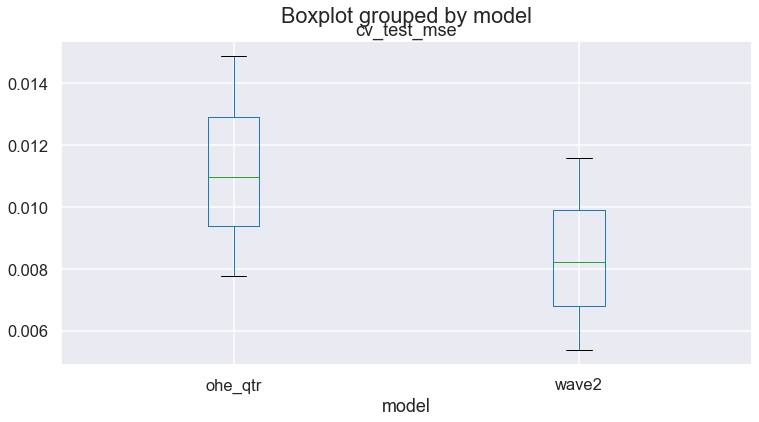

In [17]:
seas_cv_res_df.boxplot('cv_test_mse', by='model')
plt.show()

# Wave vs OHE fit

## Time Series Split

In [18]:
X_train = cnmc_df.loc[:'2018', ['month', 'qtr']].copy()
X_test = cnmc_df.loc['2019', ['month', 'qtr']].copy()

In [19]:
X_train_ohe = pd.get_dummies(X_train['qtr'], drop_first=True)
X_test_ohe = pd.get_dummies(X_test['qtr'], drop_first=True)

In [20]:
X_train_wave = mle_ts.get_wave_features(X_train['month'], periods=[12], n_harmonics=1)
X_test_wave = mle_ts.get_wave_features(X_test['month'], periods=[12], n_harmonics=1)

In [21]:
y_train = cnmc_df.loc[:'2018', 'cons_GOA'].copy()
y_test = cnmc_df.loc['2019', 'cons_GOA'].copy()

In [22]:
import statsmodels.api as sm

In [23]:
exog_ohe1 = sm.add_constant(X_train_ohe)
model_ohe1 = sm.OLS(y_train, exog_ohe1)
res_ohe1 = model_ohe1.fit()

res_ohe1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               cons_GOA   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     5.041
Date:                Wed, 07 Apr 2021   Prob (F-statistic):            0.00567
Time:                        22:50:33   Log-Likelihood:                 36.495
No. Observations:                  36   AIC:                            -64.99
Df Residuals:                      32   BIC:                            -58.66
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8181      0.031     58.570      0.000       1.755       1.881
2              0.1313      0.044      2.990      0.005       0.042       0.221
3              0.1524      0.044      3.471      0.002       0.063       0.242
4              0.0591      0.044      1.347      0.187      -0.030       0.149
==============================================================================
Omnibus:                        1.241   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.538   Jarque-Bera (JB):                1.222
Skew:                           0.356   Prob(JB):                        0.543
Kurtosis:                       2.446   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
y_train.groupby(y_train.index.quarter).mean()

Date
1   1.8181
2   1.9494
3   1.9705
4   1.8773
Name: cons_GOA, dtype: float64

In [25]:
y_train.groupby(y_train.index.quarter).mean() - y_train.loc[y_train.index.quarter==1].mean()

Date
1   0.0000
2   0.1313
3   0.1524
4   0.0591
Name: cons_GOA, dtype: float64

In [26]:
exog_ohe2 = pd.get_dummies(y_train.index.quarter)
exog_ohe2.index = y_train.index
exog_ohe2 = sm.add_constant(exog_ohe2)
model_ohe2 = sm.OLS(y_train, exog_ohe2)
res_ohe2 = model_ohe2.fit()

res_ohe2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               cons_GOA   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     5.041
Date:                Wed, 07 Apr 2021   Prob (F-statistic):            0.00567
Time:                        22:50:33   Log-Likelihood:                 36.495
No. Observations:                  36   AIC:                            -64.99
Df Residuals:                      32   BIC:                            -58.66
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5231      0.012    122.661      0.000       1.498       1.548
1              0.2951      0.027     10.903      0.000       0.240       0.350
2              0.4263      0.027     15.755      0.000       0.371       0.481
3              0.4474      0.027     16.534      0.000       0.392       0.503
4              0.3542      0.027     13.089      0.000       0.299       0.409
==============================================================================
Omnibus:                        1.241   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.538   Jarque-Bera (JB):                1.222
Skew:                           0.356   Prob(JB):                        0.543
Kurtosis:                       2.446   Cond. No.                     1.13e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.5e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [27]:
exog_wave = sm.add_constant(X_train_wave)
model_wave = sm.OLS(y_train, exog_wave)
res_wave = model_wave.fit()

res_wave.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               cons_GOA   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     18.00
Date:                Wed, 07 Apr 2021   Prob (F-statistic):           5.17e-06
Time:                        22:50:33   Log-Likelihood:                 42.807
No. Observations:                  36   AIC:                            -79.61
Df Residuals:                      33   BIC:                            -74.86
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.9038      0.013    148.434      0.000       1.878       1.930
comp_12_sin1     0.0141      0.018      0.778      0.442      -0.023       0.051
comp_12_cos1    -0.1079      0.018     -5.950      0.000      -0.145      -0.071
==============================================================================
Omnibus:                        1.446   Durbin-Watson:                   1.466
Prob(Omnibus):                  0.485   Jarque-Bera (JB):                1.038
Skew:                           0.102   Prob(JB):                        0.595
Kurtosis:                       2.193   Cond. No.                         1.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
y = cnmc_df['cons_GOA']

p_diff = cnmc_df['cons_GOA'].diff(12)

In [29]:
seas_ohe_model = LinearRegression(fit_intercept=True)

seas_ohe_model = seas_ohe_model.fit(X_train_ohe, y_train)
p_train_ohe = get_preds(X_train_ohe, seas_ohe_model, name='p_train_ohe')
p_test_ohe = get_preds(X_test_ohe, seas_ohe_model, name='p_test_ohe')

In [30]:
seas_wave_model = LinearRegression(fit_intercept=True)

seas_ohe_model = seas_wave_model.fit(X_train_wave, y_train)
p_train_wave = get_preds(X_train_wave, seas_wave_model, name='p_train_wave')
p_test_wave = get_preds(X_test_wave, seas_wave_model, name='p_test_wave')

In [31]:
p_ohe = pd.concat([p_train_ohe, p_test_ohe], axis=0)
p_ohe.name = 'p_ohe'
p_wave = pd.concat([p_train_wave, p_test_wave], axis=0)
p_wave.name = 'p_wave'

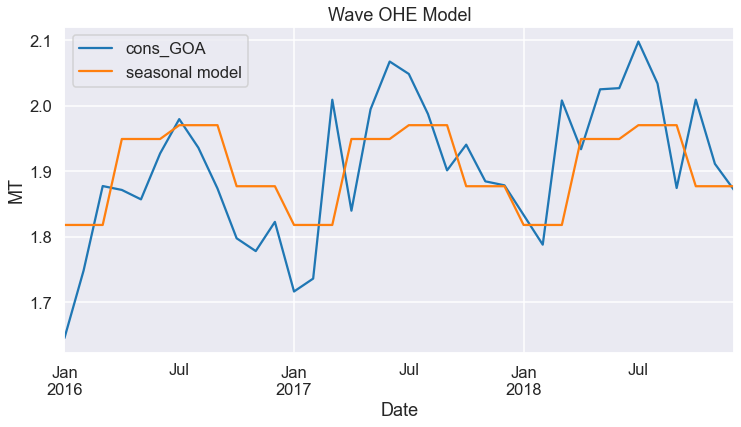

In [32]:
ax = y_train.plot()
p_train_ohe.plot(label='seasonal model', ax=ax)
plt.title('Wave OHE Model')
plt.ylabel("MT")
plt.legend()
plt.show()

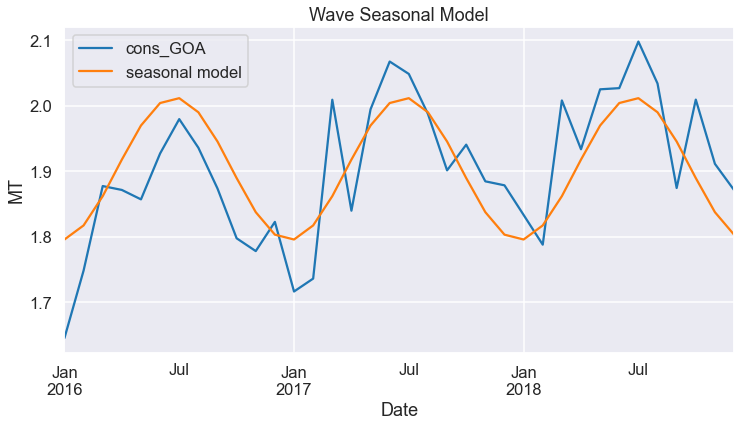

In [33]:
ax = y_train.plot()
p_train_wave.plot(label='seasonal model', ax=ax)
plt.title('Wave Seasonal Model')
plt.ylabel("MT")
plt.legend()
plt.show()

In [34]:
seas_wave_model.coef_

array([ 0.01410321, -0.10792432])

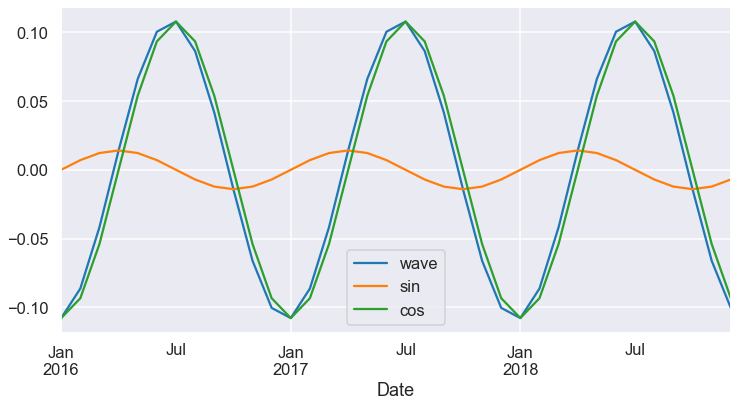

In [35]:
sin = pd.Series(index=y_train.index, data=np.sin((y_train.index.month-1)*2*np.pi/12) * seas_wave_model.coef_[0], name='sin')
cos = pd.Series(index=y_train.index, data=np.cos((y_train.index.month-1)*2*np.pi/12) * seas_wave_model.coef_[1], name='cos')

ax = (sin+cos).plot(label='wave')
sin.plot(ax=ax)
cos.plot(ax=ax)

plt.legend()
plt.show()

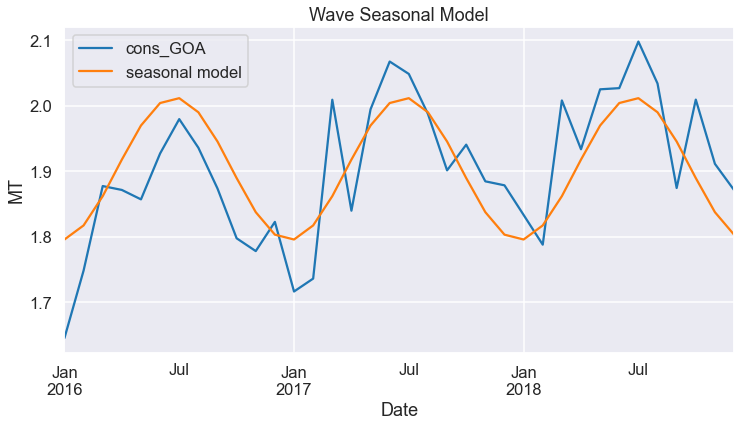

In [36]:
ax = y_train.plot()
p_train_wave.plot(label='seasonal model', ax=ax)
plt.title('Wave Seasonal Model')
plt.ylabel("MT")
plt.legend()
plt.show()

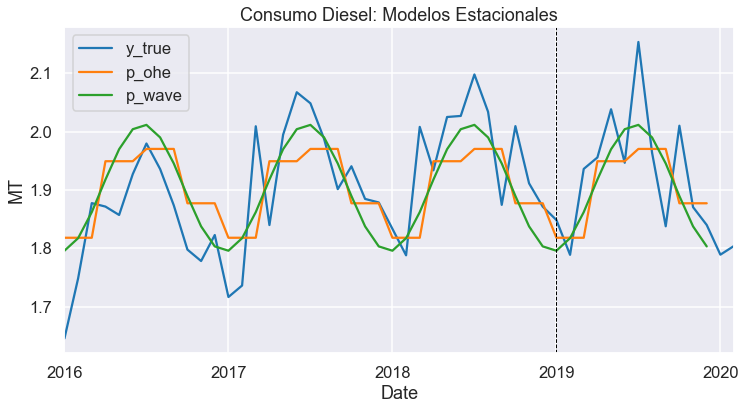

In [37]:
ax = cnmc_df.plot(y='cons_GOA', label='y_true')

p_ohe.plot(ax=ax)
p_wave.plot(ax=ax)
plt.axvline(pd.Timestamp('2019'), linestyle='--', color='black', linewidth=1)
plt.ylabel('MT')
plt.title('Consumo Diesel: Modelos Estacionales')
plt.legend()
plt.show()

In [38]:
p_ohe_adj = y - p_ohe
p_wave_adj = y - p_wave

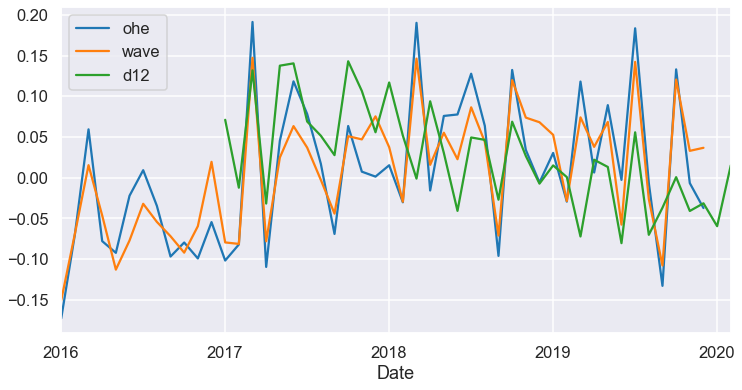

In [39]:
ax = p_ohe_adj.plot(label='ohe')
p_wave_adj.plot(label='wave', ax=ax)
p_diff.plot(label='d12', ax=ax)
plt.legend()
plt.show()